# [**Propagation d'étiquettes de chiffres : apprentissage actif**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data_science_practising/blob/main/Sklearn/examples/1_14_semi_supervised/plot_label_propagation_digits_active_learning.ipynb)<br/>([_Label Propagation digits active learning_](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html))

Ce projet démontre une technique d'apprentissage actif pour apprendre à reconnaître des chiffres manuscrits en utilisant la propagation d'étiquettes.

Nous commençons par former un modèle de propagation d'étiquettes avec seulement 10 points étiquetés, puis nous sélectionnons les cinq points les plus incertains pour les étiqueter. Ensuite, nous nous entraînons avec 15 points étiquetés (les 10 originaux + 5 nouveaux). Nous répétons ce processus quatre fois pour obtenir un modèle formé avec 30 exemples étiquetés. Notez que vous pouvez augmenter ce nombre pour étiqueter plus de 30 points en modifiant `max_iterations`. Étiqueter plus de 30 points peut être utile pour avoir une idée de la vitesse de convergence de cette technique d'apprentissage actif.

Un graphique montrera les cinq chiffres les plus incertains pour chaque itération de l'entraînement. Ils peuvent contenir des erreurs ou non, mais nous formerons le modèle suivant avec leurs véritables étiquettes.

Iteration 0 ______________________________________________________________________
Label Spreading model: 40 labeled & 290 unlabeled (330 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.78      0.69      0.73        26
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        27
           4       0.92      0.96      0.94        23
           5       0.96      0.70      0.81        33
           6       0.97      0.97      0.97        35
           7       0.94      0.91      0.92        33
           8       0.62      0.89      0.74        28
           9       0.73      0.79      0.76        34

    accuracy                           0.87       290
   macro avg       0.89      0.87      0.87       290
weighted avg       0.88      0.87      0.87       290

Confusion matrix
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 18  2  0  0  0  1  0  5  0]
 [ 0  0 27  0

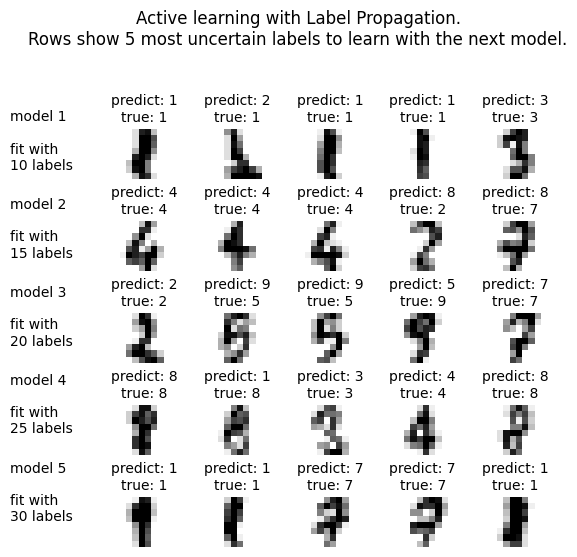

In [1]:
# Authors: Clay Woolam <clay@woolam.org>
# License: BSD

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading

digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 40
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
f = plt.figure()

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print(
        "Label Spreading model: %d labeled & %d unlabeled (%d total)"
        % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples)
    )

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.isin(uncertainty_index, unlabeled_indices)
    ][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(
            0.05,
            (1 - (i + 1) * 0.183),
            "model %d\n\nfit with\n%d labels" % ((i + 1), i * 5 + 10),
            size=10,
        )
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
            sub.set_title(
                "predict: %i\ntrue: %i"
                % (lp_model.transduction_[image_index], y[image_index]),
                size=10,
            )
            sub.axis("off")

        # labeling 5 points, remote from labeled set
        (delete_index,) = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle(
    (
        "Active learning with Label Propagation.\nRows show 5 most "
        "uncertain labels to learn with the next model."
    ),
    y=1.15,
)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2, hspace=0.85)
plt.show()